In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybaseball as pyb
import sklearn as scikit_learn 

In [ ]:
# importing model and cleaning

data = pyb.statcast('2024-04-28', '2024-09-20')
# release_speed, pfx_x, pfx_z, release_spin_rate
# pitch_name, spin_axis (affected by p_throws)

# return pitch_name

# cleaning up data
pitch_parameters = [
    'pitch_name', 
    'release_speed', 
    'pfx_x', 'pfx_z', 
    'release_spin_rate', 
    'spin_axis', 
    'p_throws'
]

data = data[pitch_parameters]

# cleaning up pitch_name 
excluded_values = [
    'Pitch Out', 
    'Other', 
    'Eephus', 
    'Slurve', 
    
    # added these
    #'Knuckle Curve'
    #'Forkball'
]
data = data[~data['pitch_name'].isin(excluded_values)]

# removing na values in pitch_name
data.dropna(subset=['pitch_name'], inplace=True)
data = data.dropna()

# converting movement to inches
data['pfx_x'] = data['pfx_x'] * 12
data['pfx_z'] = data['pfx_z'] * 12 

data.shape

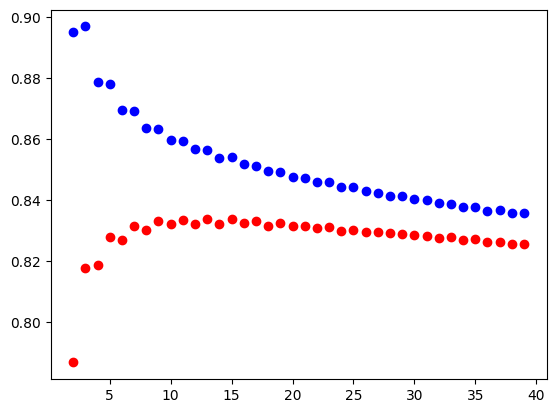

In [23]:
# KNN 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# changing p_throws to a numerical value by mapping and replacing
pitching_hand = {'R':0, 'L':1}
data['p_throws'] = data['p_throws'].replace(pitching_hand)

# splitting data    
x_data_split = [
    'release_speed', 
    'pfx_x', 'pfx_z', 
    'release_spin_rate', 
    'spin_axis', 
    'p_throws'
]

X = data[x_data_split]
y = data['pitch_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# training the model
K, training, test, scores = [], [], [], {}

for k in range(2, 40):
    clf = KNeighborsClassifier(n_neighbors=k, p=1, metric='manhattan')
    clf.fit(X_train, y_train)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

plt.scatter(K, training, c='blue')
plt.scatter(K, test, c='red')
plt.show()

In [19]:
# the model sucked in its first iteration

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)
scores

# returns close to 50% which basically means this model is guessing
# might be because there's too many pitch types

# seems to struggle because of the initial high number of data and number of dimensions
# changing number of dimensions to simply movement and spin axis

# limiting the dimensions/features to simply release speed and movement had the best results
# also limited the data to just one day of data
# realized that the more dimensions you have, volume of space increases exponentially

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


array([0.77929493, 0.79211083, 0.7946261 , 0.79658243, 0.79593548])